### Imports

In [10]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from neuropy.analyses import ExplainedVariance
import pingouin as pg
from scipy import stats
import subjects

sessions = subjects.nsd.remaze + subjects.sd.remaze

### EV remaze example sessions for figure3

In [5]:
example_sessions = subjects.nsd.ratUday2 + subjects.sd.ratUday4
expvar_df,brainstates_all =[],[]
for sub, sess in enumerate(tqdm(example_sessions)):
    pre = sess.paradigm["pre"].flatten()
    maze = sess.paradigm["maze"].flatten()
    post = sess.paradigm["post"].flatten()
    remaze = sess.paradigm["re-maze"].flatten()
    states = sess.brainstates.time_slice(post[0], remaze[1])
    df = pd.DataFrame(
        dict(
            start=states.starts,
            stop=states.stops,
            label=states.labels,
            sub=sub,
            name=sess.animal.name,
            grp=sess.tag,
        )
    )
    brainstates_all.append(df)

    neurons = sess.neurons.get_neuron_type("pyr")
    wave_similarity = neurons.get_waveform_similarity()
    pairs_bool = wave_similarity < 0.8  # only pairs which are least similar

    expvar = ExplainedVariance(
        neurons=neurons,
        template=maze,
        matching=[post[0],remaze[1]],
        control=pre,
        window=900,
        slideby=300,
        pairs_bool=pairs_bool,
        ignore_epochs=sess.artifact,
    )
    expvar_df.append(
        pd.DataFrame(
            {
                "ev": expvar.ev,
                "ev_std": expvar.ev_std,
                "rev": expvar.rev,
                "rev_std": expvar.rev_std,
                "Zt": (expvar.matching_time - post[0]) / 3600,
                "sub": sub,
                "name": sess.sub_name,
                'sex':sess.animal.sex,
                "grp": sess.tag,
            }
        ),
    )

brainstates_all = pd.concat(brainstates_all, ignore_index=True)
expvar_df = pd.concat(expvar_df,ignore_index=True)

subjects.GroupData().save([expvar_df,brainstates_all], "remaze_ev_example")

  0%|          | 0/2 [00:00<?, ?it/s]

remaze_ev_example saved


### Pooled across sessions

In [ ]:
print(len(sessions))
expvar_df =[]
for sub, sess in enumerate(tqdm(sessions)):
    pre = sess.paradigm["pre"].flatten()
    maze = sess.paradigm["maze"].flatten()
    if maze.size == 0:
        maze = sess.paradigm["maze1"].flatten()
    post = sess.paradigm["post"].flatten()

    neurons = sess.neurons.get_neuron_type("pyr")
    wave_similarity = neurons.get_waveform_similarity()
    pairs_bool = wave_similarity < 0.8  # only pairs which are least similar

    expvar = ExplainedVariance(
        neurons=neurons,
        template=maze,
        matching=post,
        control=pre,
        slideby=300,
        pairs_bool=pairs_bool,
        ignore_epochs=sess.artifact,
    )
    expvar_df.append(
        pd.DataFrame(
            {
                "ev": expvar.ev,
                "ev_std": expvar.ev_std,
                "rev": expvar.rev,
                "rev_std": expvar.rev_std,
                "Zt": (expvar.matching_time - post[0]) / 3600,
                "sub": sub,
                "name": sess.sub_name,
                'sex':sess.animal.sex,
                "grp": sess.tag,
            }
        ),
    )

expvar_df = pd.concat(expvar_df,ignore_index=True)

subjects.GroupData().save(expvar_df, "remaze_ev_pooled")


In [ ]:
%matplotlib widget
import pandas as pd
import seaborn as sns
import numpy as np

figure = Fig()
fig,gs = figure.draw(grid=(1,1),style='Pres')

df = pd.DataFrame()
for grp,expvars in enumerate([sd_expvar,nsd_expvar]):
    for i,expvar in enumerate(expvars): 
        ev_diff = expvar.ev - expvar.rev
        ev_bins = np.arange(len(ev_diff))
        df = df.append(pd.DataFrame({'ev_diff':ev_diff,'bins':ev_bins,'grp':grp}),ignore_index=True)

ax = plt.subplot(gs[0])
sns.lineplot(data=df,x='bins',y='ev_diff',hue='grp',ci=None,ax=ax,linewidth=3,palette=['r','k'])
ax.set_ylabel('Explained variance (above chance level)')
ax.set_xlabel('ZT bins')

### EV compare during re-maze SD vs NSD

In [ ]:
from neuropy.analyses import ExplainedVariance
import pingouin as pg

remaze_df = [] 
for sub, sess in enumerate(tqdm(sessions)):
    pre = sess.paradigm["pre"].flatten()
    maze = sess.paradigm["maze"].flatten()
    remaze = sess.paradigm["re-maze"].flatten()

    neurons = sess.neurons.get_neuron_type("pyr")
    wave_similarity = neurons.get_waveform_similarity()
    pairs_bool = wave_similarity < 0.8  # only pairs which are least similar

    get_corr = lambda epoch: (
            neurons.time_slice(epoch[0], epoch[1])
            .get_binned_spiketrains(bin_size=0.25,ignore_epochs=sess.artifact)
            .get_pairwise_corr(pairs_bool=pairs_bool)
        )

    pre_corr = get_corr(pre)
    maze_corr = get_corr(maze)
    remaze_corr = get_corr(remaze)

    df = pd.DataFrame(dict(pre=pre_corr,maze=maze_corr,remaze=remaze_corr))
    ev = pg.partial_corr(data=df,x='maze',y='remaze',covar='pre')
    rev = pg.partial_corr(data=df,x='maze',y='pre',covar='remaze')

    remaze_df.append(
        pd.DataFrame(
            {
                "ev": [ev.r.values[0]**2,rev.r.values[0]**2],
                "ev_name": ['ev','rev'],
                "t": 'remaze',
                "sub": sub,
                "name": sess.sub_name,
                'sex':sess.animal.sex,
                "grp": sess.tag,
            }
        )
    )

remaze_df = pd.concat(remaze_df,ignore_index=True)
subjects.GroupData().save(remaze_df, "remaze_ev")

In [ ]:
%matplotlib widget
import seaborn as sns

sns.boxplot(data=remaze_df,x='grp',y='ev',hue='ev_name',palette=['#616161','#BDBDBD'])

### EV on REMAZE of POST while controlling for both PRE and MAZE combined together

In [ ]:
from neuropy.analyses import ExplainedVariance

expvar_df = []
for sub, sess in enumerate(tqdm(sessions)):
    pre = sess.paradigm["pre"].flatten()
    maze = sess.paradigm["maze"].flatten()
    post = sess.paradigm["post"].flatten()
    remaze = sess.paradigm["re-maze"].flatten()

    neurons = sess.neurons.get_neuron_type("pyr")
    wave_similarity = neurons.get_waveform_similarity()
    pairs_bool = wave_similarity < 0.8  # only pairs which are least similar

    expvar = ExplainedVariance(
        neurons=neurons,
        template=post,
        matching=remaze,
        control=[pre[0], maze[1]],
        window=None,
        slideby=None,
        pairs_bool=pairs_bool,
        ignore_epochs=sess.artifact,
    )

    expvar_df.append(
        pd.DataFrame(
            dict(
                ev_value=[expvar.ev[0],expvar.rev[0]],
                ev_type=['ev','rev'],
                epoch='remaze',
                sub=sub,
                name=sess.sub_name,
                sex=sess.animal.sex,
                grp=sess.tag,
            )
        ),
    )

expvar_df = pd.concat(expvar_df, ignore_index=True)
subjects.GroupData().save(expvar_df, "remaze_ev_of_post")


In [ ]:
%matplotlib widget
from neuropy import plotting 
import pandas as pd
import seaborn as sns
import numpy as np

fig = plotting.Fig(grid=(1,1))
ax = fig.subplot(fig.gs[0])

sns.barplot(data=expvar_df,x='grp',y='ev_value',hue='ev_type')


### EV of remaze during SD vs NSD
- once crontrolling for PRE
- once crontrolling for MAZE
- once crontrolling for both PRE and MAZE

In [8]:
from neuropy.analyses import ExplainedVariance

expvar_df = []
for sub, sess in enumerate(tqdm(sessions)):
    pre = sess.paradigm["pre"].flatten()
    maze = sess.paradigm["maze"].flatten()
    post = sess.paradigm["post"].flatten()
    remaze = sess.paradigm["re-maze"].flatten()

    neurons = sess.neurons.get_neuron_type("pyr")
    wave_similarity = neurons.get_waveform_similarity()
    pairs_bool = wave_similarity < 0.8  # only pairs which are least similar

    epochs= [[post[0],post[0]+5*3600],[post[0]+5*3600,post[1]]]
    epoch_names = ['Zt0-5','Zt5-end']

    for e,e_name in zip(epochs,epoch_names):
        expvar = ExplainedVariance(
            neurons=neurons,
            template=remaze,
            matching=e,
            control=maze,
            window=None,
            slideby=None,
            pairs_bool=pairs_bool,
            ignore_epochs=sess.artifact,
        )


        expvar_df.append(
            pd.DataFrame(
                dict(
                    ev_value=[expvar.ev[0],expvar.rev[0]],
                    ev_type=['ev','rev'],
                    epoch=e_name,
                    sub=sub,
                    name=sess.sub_name,
                    sex=sess.animal.sex,
                    grp=sess.tag,
                )
            ),
        )

expvar_df = pd.concat(expvar_df, ignore_index=True)
# subjects.GroupData().save(expvar_df, "remaze_ev_on_zt0to5")


  0%|          | 0/6 [00:00<?, ?it/s]

Ttest_1sampResult(statistic=4.700096710803842, pvalue=0.0011200178871001584)

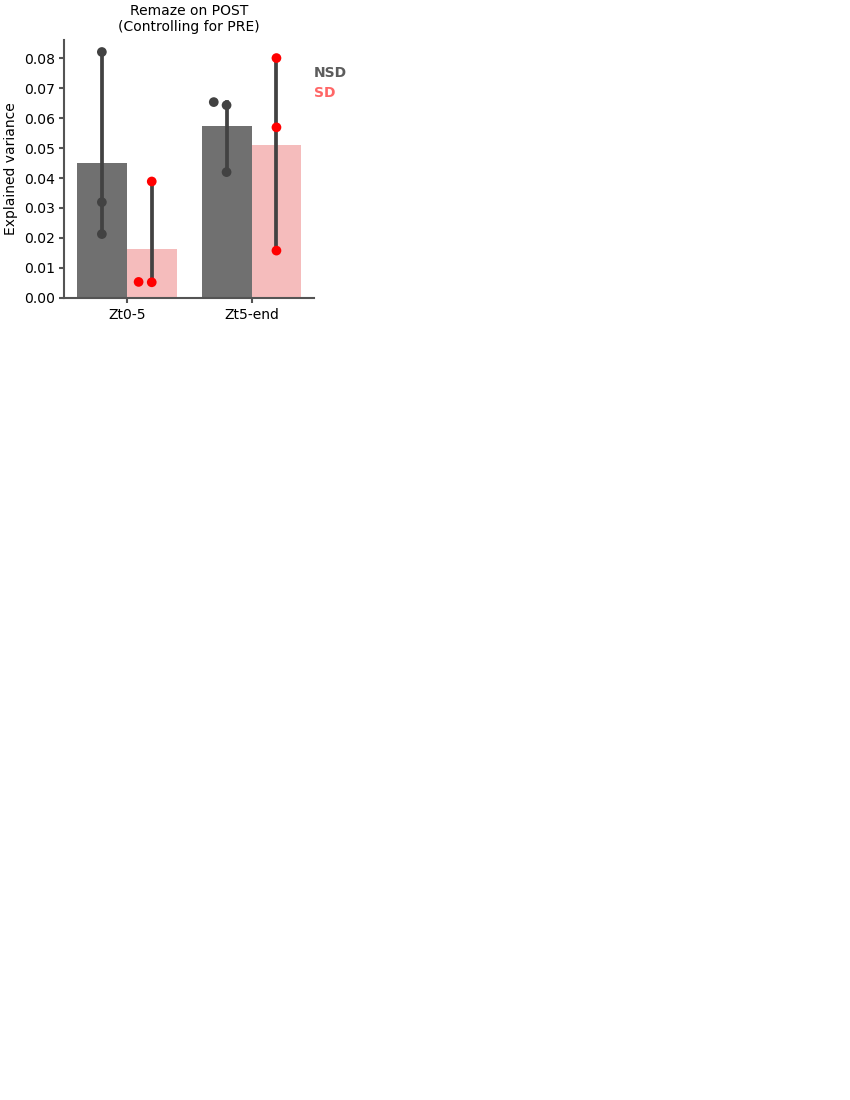

In [9]:
%matplotlib widget
from neuropy import plotting
import seaborn as sns
from scipy import stats

fig = plotting.Fig(grid=(4, 3), fontsize=10)
ax = fig.subplot(fig.gs[0])

df = expvar_df[expvar_df["ev_type"] == "ev"]
sns.barplot(
    data=df, x="epoch", y="ev_value", hue="grp", palette=subjects.colors_sd(1.7)
)
sns.swarmplot(
    data=df,
    x="epoch",
    y="ev_value",
    hue="grp",
    palette=subjects.colors_sd(1),
    size=7,
    dodge=True,
)

ax.set_ylabel("Explained variance")
ax.set_xlabel("")
ax.set_title("Remaze on POST\n(Controlling for PRE)")
ax.legend("", frameon=False)
fig.legend(ax,['NSD','SD'],color=subjects.colors_sd(1.4),x=1,dy=0.08,fontsize=10)
stats.ttest_1samp(np.arange(10),0)


In [ ]:

from statsmodels.stats.descriptivestats import sign_test

nsd_bool = (df.epoch=='Zt0-5')&(df.grp=='NSD')
df_nsd = df[nsd_bool].ev_value

sd_bool = (df.epoch=='Zt0-5')&(df.grp=='SD')
df_sd = df[sd_bool].ev_value

# stats.wilcoxon(df_new.ev_value,alternative='greater')
stats.ttest_ind(df_nsd,df_sd,alternative='greater')

### Remaze EV temporal evolution during POST while controlling for MAZE

In [13]:
print(f'#Sessions = {len(sessions)}')
expvar_df,brainstates_all =[],[]
for sub, sess in enumerate(tqdm(sessions)):
    pre = sess.paradigm["pre"].flatten()
    maze = sess.paradigm["maze"].flatten()
    post = sess.paradigm["post"].flatten()
    remaze = sess.paradigm["re-maze"].flatten()
    states = sess.brainstates.time_slice(post[0], post[1])
    states_df = pd.DataFrame(
        dict(
            start=states.starts,
            stop=states.stops,
            label=states.labels,
            sub=sub,
            name=sess.animal.name,
            grp=sess.tag,
        )
    )
    brainstates_all.append(states_df)

    neurons = sess.neurons.get_neuron_type("pyr")
    wave_similarity = neurons.get_waveform_similarity()
    pairs_bool = wave_similarity < 0.8  # only pairs which are least similar

    expvar = ExplainedVariance(
        neurons=neurons,
        template=remaze,
        matching=[post[0],post[1]],
        control=maze,
        window=900,
        slideby=300,
        pairs_bool=pairs_bool,
        ignore_epochs=sess.artifact,
    )
    expvar_df.append(
        pd.DataFrame(
            {
                "ev": expvar.ev,
                "ev_std": expvar.ev_std,
                "rev": expvar.rev,
                "rev_std": expvar.rev_std,
                "Zt": (expvar.matching_time - post[0]) / 3600,
                "sub": sub,
                "name": sess.sub_name,
                'sex':sess.animal.sex,
                "grp": sess.tag,
            }
        ),
    )

brainstates_all = pd.concat(brainstates_all, ignore_index=True)
expvar_df = pd.concat(expvar_df,ignore_index=True)

# subjects.GroupData().save([expvar_df,brainstates_all], "remaze_ev_on_POST_example")
subjects.GroupData().save([expvar_df,brainstates_all], "remaze_ev_on_POST_pooled")

#Sessions = 6


  0%|          | 0/6 [00:00<?, ?it/s]

remaze_ev_on_POST_pooled saved
